In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [9]:
def collect_data_and_plot(df, n_stores, n_warehouses, n_samples, test_mode, setting_name):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'] + '/model.pt',
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/{n_stores}-{n_warehouses}/{row['Architecture Class']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 8:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_cost = []
    w_holding_by_warehouse_all = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        batch_size = n_samples
        num_batches = n_samples // batch_size
        if test_mode == 'test_on_dev':
            num_steps = 100
            start_step = 30
        else:
            num_steps = 200
            start_step = 100
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        avg_s_underage.append(relevant_data['s_underage_costs'].sum())
        avg_s_holding.append(relevant_data['s_holding_costs'].sum())
        # Split warehouse holding costs by warehouse
        w_holding_costs = []
        for i in range(n_warehouses):
            w_holding_costs.append(relevant_data[f'w_{i}_holding_costs'].sum())
        w_holding_by_warehouse_all.append(w_holding_costs)
        avg_w_holding.append(sum(w_holding_costs))  # Total warehouse holding cost
        avg_cost.append(relevant_data['s_underage_costs'].sum() + relevant_data['s_holding_costs'].sum() + avg_w_holding[-1])

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = avg_s_underage # Not negating since we want lost sales
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding
    
    # Add individual warehouse holding costs
    for i in range(n_warehouses):
        df_copy[f'w_{i}_holding'] = [x[i] for x in w_holding_by_warehouse_all]
        
    df_copy['avg_lost_sales'] = avg_cost # This is now lost sales since we didn't negate the costs
    df = df_copy

    # Calculate relative lost sales as percentage of minimum overall lost sales
    min_lost_sales = df['avg_lost_sales'].min()
    df['lost_sales'] = df['avg_lost_sales'] / min_lost_sales * 100

    plot_data = df.pivot(columns='Architecture Class', 
                        values=['lost_sales', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'] + 
                        [f'w_{i}_holding' for i in range(n_warehouses)])
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Loss (% of minimum)', 'Store Lost Sales(1e7)', 'Store Holding Cost(1e7)', 
             'Total Warehouse Holding Cost(1e7)', 'Individual Warehouse Holding Costs(1e7)']
    y_values = ['lost_sales', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    # Create a single legend at the top
    legend_lines = []
    legend_labels = []
    for arch in df['Architecture Class'].unique():
        legend_lines.append(plt.Line2D([0], [0], color=color_scheme[arch], 
                                     linestyle=linestyle_scheme[arch], marker='o', markersize=10))
        legend_labels.append(arch)
    
    fig.legend(legend_lines, legend_labels, loc='upper center', 
              bbox_to_anchor=(0.5, 0.98), ncol=len(legend_labels))

    for i, (ax, title, y_value) in enumerate(zip(axes[:-1], titles[:-1], y_values)):
        for arch in df['Architecture Class'].unique():
            if arch in plot_data[y_value].columns:
                plot_values = plot_data[y_value][arch].to_numpy()
                if y_value != 'lost_sales':
                    plot_values = plot_values / 1e7  # Scale down non-lost_sales values by 1e7
                x_values = np.ones_like(plot_values)  # Create x values with same dimension as plot_values
                ax.plot(x_values, plot_values, marker='o', markersize=10,
                       color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_ylabel(title)
        ax.set_title(title)
        ax.grid(True)
        ax.set_xticks([]) # Remove x-axis ticks

    # Plot individual warehouse holding costs
    for arch in df['Architecture Class'].unique():
        # Plot all points without labels since legend is at the top
        for i in range(n_warehouses):
            if arch in plot_data[f'w_{i}_holding'].columns:
                plot_values = plot_data[f'w_{i}_holding'][arch].to_numpy() / 1e7
                x_values = np.ones_like(plot_values) * (i + 1)
                axes[-1].plot(x_values, plot_values, marker='o', markersize=10,
                            color=color_scheme[arch], linestyle=linestyle_scheme[arch])

    axes[-1].set_ylabel('Warehouse Holding Cost(1e7)')
    axes[-1].set_title('Individual Warehouse Holding Costs(1e7)')
    axes[-1].grid(True)
    axes[-1].set_xticks(range(1, n_warehouses + 1))
    axes[-1].set_xticklabels([f'W{i}' for i in range(n_warehouses)])

    plt.tight_layout()
    # Adjust layout to make room for the legend at the top
    plt.subplots_adjust(top=0.92)
    plt.show()
    return df


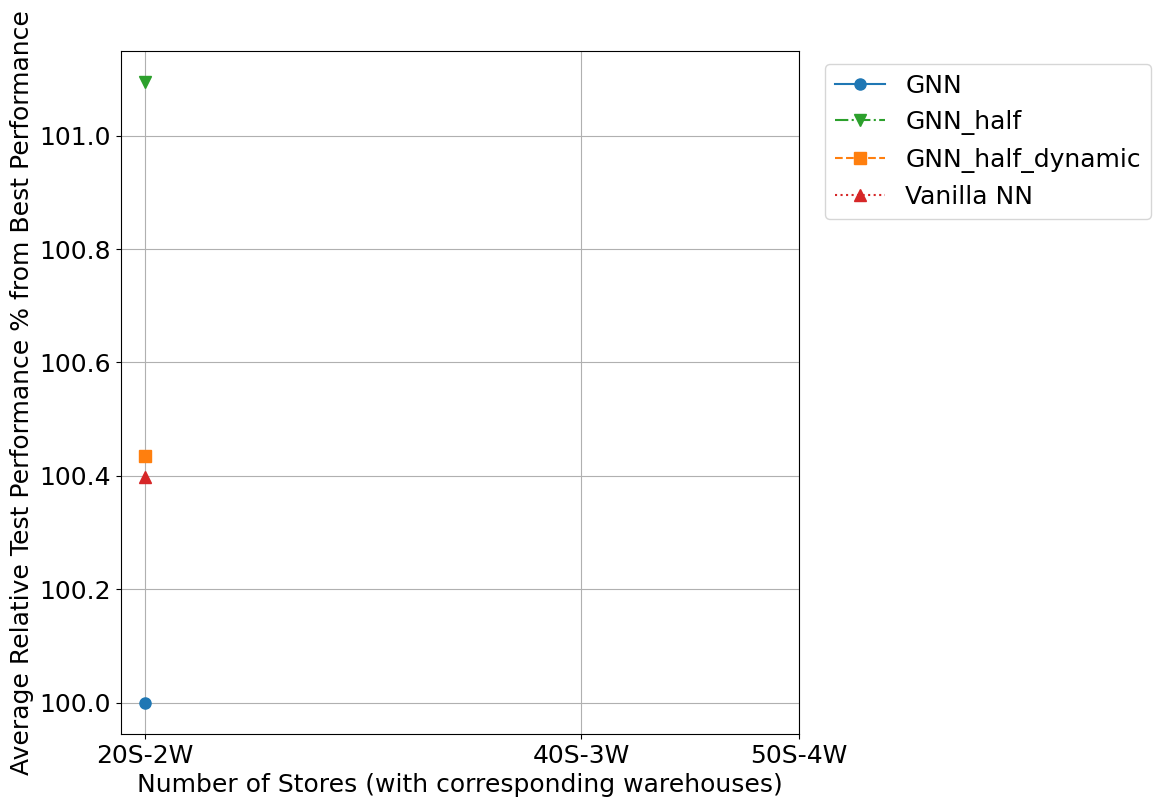

In [14]:
# Create vanilla results dataframe from the provided data
testset_names = ["n_warehouse_20_2_exp_capped"]#, "n_warehouse_40_3_exp_capped", "n_warehouse_50_4_exp_capped"]
store_warehouse_pairs = {
    20: 2,
    40: 3,
    50: 4
}

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme and markers for architectures
color_scheme = {
    "GNN": "#1f77b4",         # Blue
    "GNN_half": "#2ca02c",    # Green
    "GNN_half_dynamic": "#ff7f0e", # Orange
    "Vanilla NN": "#d62728",   # Red
    "GNN_bottleneck": "#9467bd", # Purple
    "GNN_skip_connection": "#8c564b" # Brown
}

linestyle_scheme = {
    "GNN": "-",         # Solid
    "GNN_half": "-.",   # Dash-dot
    "GNN_half_dynamic": "--", # Dashed
    "Vanilla NN": ":",    # Dotted
    "GNN_bottleneck": "-", # Solid
    "GNN_skip_connection": "--" # Dashed
}

marker_scheme = {
    "GNN": "o",          # Circle
    "GNN_half": "v",     # Down triangle
    "GNN_half_dynamic": "s", # Square
    "Vanilla NN": "^",     # Up triangle
    "GNN_bottleneck": "D", # Diamond
    "GNN_skip_connection": "p" # Pentagon
}

# Define paths for each architecture
architectures = {
    "GNN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN',
    "GNN_half": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_half',
    "GNN_half_dynamic": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_half_dynamic',
    "Vanilla NN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/vanilla_n_warehouses',
    # "GNN_bottleneck": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_bottleneck',
    # "GNN_skip_connection": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_skip_connection'
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define store sizes and sample size
store_sizes = [20, 40, 50]  # Corresponding to the testset names
sample_size = 8192

dfs = []

# Create dataframes for each architecture and store size
for arch_name, path_fn in architectures.items():
    for testset_name in testset_names:
        path = path_fn(testset_name)
        store_size = int(testset_name.split('_')[2])
        warehouse_size = store_warehouse_pairs[store_size]
        
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': [sample_size],
             'samples': [1]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
            test_loss_limit = 100)
        if df.empty:
            continue
        
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        df['train_dev_sample_and_batch_size'] = sample_size
        df['n_warehouses'] = warehouse_size
        df['n_stores'] = store_size
        dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate gap percentage using best performing loss for each store size
stats_by_arch_and_stores = {}
for store_size in store_sizes:
    store_data = df[df['n_stores'] == store_size].copy()
    if store_data.empty:
        continue
    best_test_loss = store_data['Test Loss'].min()
    store_data.loc[:, 'Relative Test Performance %'] = (store_data['Test Loss']/ best_test_loss) * 100 
    
    for arch in store_data['Architecture Class'].unique():
        key = arch
        if key not in stats_by_arch_and_stores:
            stats_by_arch_and_stores[key] = []
            
        arch_data = store_data[store_data['Architecture Class'] == arch]
        if not arch_data.empty:
            relative_performance = arch_data['Relative Test Performance %'].to_numpy()
            mean_relative_performance = np.mean(relative_performance)
            std_relative_performance = np.std(relative_performance)
            ci_95 = 1.96 * std_relative_performance / np.sqrt(len(relative_performance))
            stats_by_arch_and_stores[key].append({
                'n_stores': store_size,
                'mean_relative_performance': mean_relative_performance,
                'ci_lower': mean_relative_performance - ci_95,
                'ci_upper': mean_relative_performance + ci_95
            })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch, stats in stats_by_arch_and_stores.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Convert pandas series to numpy arrays before plotting
        stores_array = stats_df['n_stores'].to_numpy()
        mean_relative_performance_array = stats_df['mean_relative_performance'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(stores_array, mean_relative_performance_array,
                marker=marker_scheme[arch],
                color=color_scheme[arch],
                linestyle=linestyle_scheme[arch],
                markersize=8,
                label=arch)
        
        plt.fill_between(stores_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[arch],
                        alpha=0.1)

plt.xlabel('Number of Stores (with corresponding warehouses)', fontsize=FONTSIZE)
plt.ylabel('Average Relative Test Performance % from Best Performance', fontsize=FONTSIZE)
plt.grid(True)

# Create single legend
plt.legend(bbox_to_anchor=(1.02, 1),
          loc='upper left',
          fontsize=FONTSIZE)

# Update x-axis ticks to show store-warehouse pairs
plt.xticks(store_sizes, [f'{s}S-{store_warehouse_pairs[s]}W' for s in store_sizes], fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

In [15]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,samples,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,n_warehouses,n_stores
0,1,GNN,8192,GNN,1,0.001,23.446455,23.485371,23.418652,8,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20
1,1,GNN_half,8192,GNN_half,1,0.001,23.714676,23.742363,23.674965,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20
2,1,GNN_half_dynamic,8192,GNN_half_dynamic,1,0.001,23.526391,23.585558,23.520477,7,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20
3,1,Vanilla NN,8192,Vanilla NN,1,0.001,23.456616,23.575042,23.511771,7,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20


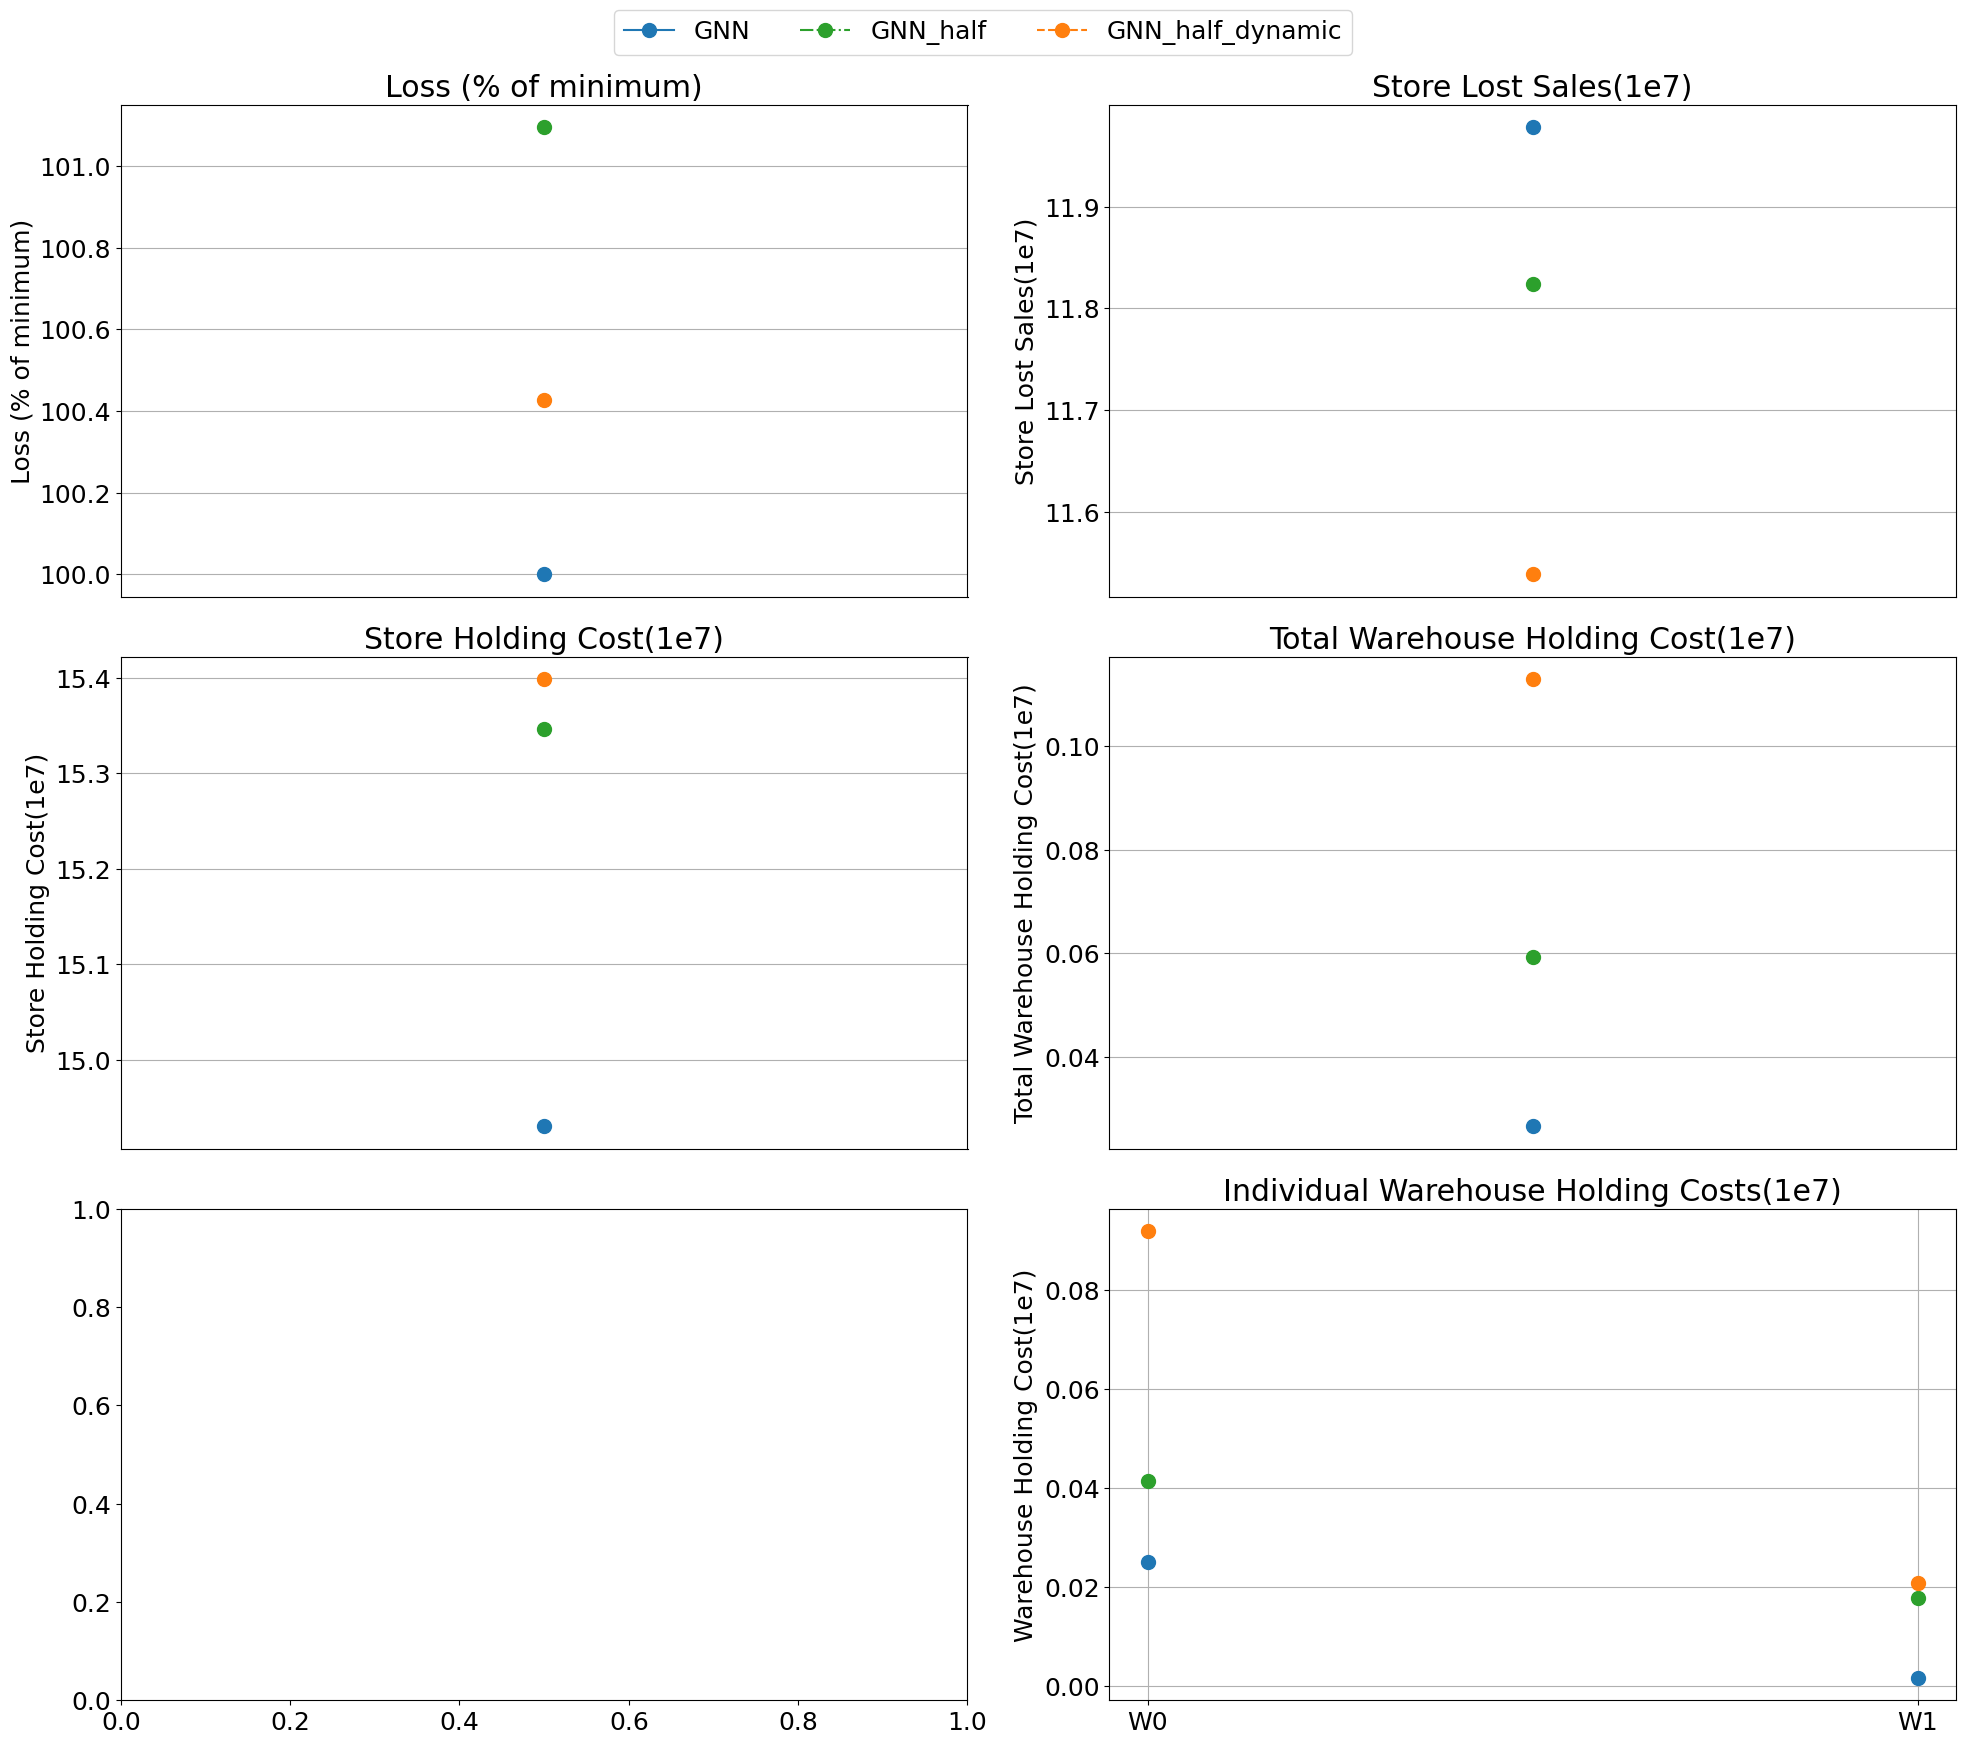

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,samples,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,n_warehouses,n_stores,avg_s_underage,avg_s_holding,avg_w_holding,w_0_holding,w_1_holding,avg_lost_sales,lost_sales
0,1,GNN,8192,GNN,1,0.001,23.446455,23.485371,23.418652,8,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20,1.197790e+08,1.493031e+08,2.669821e+05,250270.787106,16711.344837,2.693491e+08,100.000000
1,1,GNN_half,8192,GNN_half,1,0.001,23.714676,23.742363,23.674965,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20,1.182370e+08,1.534667e+08,5.927015e+05,414354.307996,178347.239802,2.722964e+08,101.094249
2,1,GNN_half_dynamic,8192,GNN_half_dynamic,1,0.001,23.526391,23.585558,23.520477,7,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20,1.153839e+08,1.539855e+08,1.128629e+06,919848.732701,208780.185178,2.704981e+08,100.426589


In [17]:
df_analysis = df[df['n_warehouses'] == 2]
df_analysis = df_analysis[df_analysis['Architecture Class'] != 'Vanilla NN']
collect_data_and_plot(df_analysis, 20, 2, 8192, "test_on_dev", "n_warehouse_20_2_lost_demand_exp_capped")

In [3]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,samples,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,n_warehouses,n_stores
0,1,GNN,8192,GNN,1,0.001,17.797121,17.851561,17.817895,7,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20
1,1,GNN,8192,GNN,1,0.001,15.445524,15.396363,15.403357,7,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40
2,1,GNN,8192,GNN,1,0.001,15.147439,15.118507,15.118355,6,/user/ml4723/Prj/NIC/ray_results/n_warehouse_5...,4,50
3,1,GNN_half,8192,GNN_half,1,0.001,18.341414,18.369586,18.328262,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_2...,2,20
4,1,GNN_half,8192,GNN_half,1,0.010,16.005167,15.938710,15.940875,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40
5,1,GNN_half,8192,GNN_half,1,0.010,15.597224,15.550777,15.568608,8,/user/ml4723/Prj/NIC/ray_results/n_warehouse_5...,4,50


In [5]:
pd.DataFrame([
    {
        'Architecture': arch,
        'Stores': stats['n_stores'],
        'Mean Gap %': stats['mean_gap'],
        'CI Lower': stats['ci_lower'],
        'CI Upper': stats['ci_upper']
    }
    for (arch), stats_list in stats_by_arch_and_stores.items()
    for stats in stats_list
]).pivot_table(
    index=['Architecture'],
    columns='Stores',
    values='Mean Gap %',
    aggfunc='first'
).round(2)

Stores,20
Architecture,
GNN,0.00
GNN_half,0.89
